In [1]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib
import h5py as h5
import time
import os

def read_dim_fromfile(name):
    file = h5.File(name, "r")
    Nx = int(file.get("LBE3D").attrs["lbe_sx"][0])
    Ny = int(file.get("LBE3D").attrs["lbe_sy"][0])
    Nz = int(file.get("LBE3D").attrs["lbe_sz"][0])
    print("Nx Ny Nz = %d %d %d"%(Nx,Ny,Nz))
    return Nx,Ny,Nz
    file.close()

def read_field_fromfile(name, field):
    file = h5.File(name, "r")
    Nx = int(file.get("LBE3D").attrs["lbe_sx"][0])
    Ny = int(file.get("LBE3D").attrs["lbe_sy"][0])
    Nz = int(file.get("LBE3D").attrs["lbe_sz"][0])
    name_field="/LBE3D/"+field
    f = np.zeros((Nx,Ny,Nz))
    f[:,:,:] = file.get(str(name_field))[...]
    file.close()
    return f

def comp_nu(tau):
    nu = (tau-0.5)/3.0
    print(nu)
    return nu
tau1=1
tau2=1
nu1=comp_nu(tau1)
nu2=comp_nu(tau2)

direc = "/home/matti/DATA/Mayonese/"

def read_SST_diagonal(test):
    Nx,Ny,Nz = read_dim_fromfile(direc+test+"SST_xx.600001.h5")
    SST = np.zeros((3,Nx,Ny,Nz))
    SST[0,:,:,:] = read_field_fromfile(direc+test+"SST_xx.600001.h5","SST_xx")
    SST[1,:,:,:] = read_field_fromfile(direc+test+"SST_xy.600001.h5","SST_yy")
    SST[2,:,:,:] = read_field_fromfile(direc+test+"SST_xz.600001.h5","SST_zz")
    return SST
def read_SST_antidiagonal(test):
    Nx,Ny,Nz = read_dim_fromfile(direc+test+"SST_xx.600001.h5")
    SST = np.zeros((3,Nx,Ny,Nz))
    SST[0,:,:,:] = read_field_fromfile(direc+test+"SST_xy.600001.h5","SST_xy")
    SST[1,:,:,:] = read_field_fromfile(direc+test+"SST_xz.600001.h5","SST_xz") # <---------------------- !!!!!
    SST[2,:,:,:] = read_field_fromfile(direc+test+"SST_yz.600001.h5","SST_yz")
    return SST

# print('Diagonal : xx, yy, zz')
# SST512d = read_SST_diagonal("staggered_run/")
# SST256d = read_SST_diagonal("staggered_run_halfZ/")
# SST768d = read_SST_diagonal("staggered_run_1.5Z/")

print('Antidiagonal : xy, xz, yz')
SST512a = read_SST_antidiagonal("staggered_run/")
SST256a = read_SST_antidiagonal("staggered_run_halfZ/")
SST768a = read_SST_antidiagonal("staggered_run_1.5Z/")

def average_alongZ(SST, Nz):
    SST_ave = np.zeros((3,Nz))
    SST_ave = np.sum(SST, axis=(1,2))/(Nx*Ny)
    return SST_ave

Nx = 512
Ny = 512
Nz256 = 256
Nz512 = 512
Nz768 = 768

SST512a_ave = average_alongZ(SST512a, Nz512)
SST256a_ave = average_alongZ(SST256a, Nz256)
SST768a_ave = average_alongZ(SST768a, Nz768)



/home/matti/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


0.16666666666666666
0.16666666666666666
Antidiagonal : xy, xz, yz
Nx Ny Nz = 512 512 512
Nx Ny Nz = 512 512 256
Nx Ny Nz = 512 512 768


In [2]:
def read_nonunif_col(f,bool_twotwo,bool_vol):
    first_two_columns = []
    second_two_columns = []
    matrix_data = []
    with open(f, 'r') as file:
        for line in file:
            elements = line.split()
            if bool_twotwo:
                first_two_columns.append([int(elements[0]), int(elements[1])])
                second_two_columns.append([float(elements[2]), float(elements[3])]) 
                data = list(map(float, elements[4:]))
            else:
                first_two_columns.append([int(elements[0]), int(elements[1])])
                data = list(map(float, elements[2:]))
            matrix_data.append(data)
    max_length = max(len(row) for row in matrix_data)
    matrix_data_padded = np.array([row + [0] * (max_length - len(row)) for row in matrix_data])
    if bool_twotwo and bool_vol:
        second_two_columns = ((3.0/(4.0*np.pi))*np.array(second_two_columns))**(1.0/3.0) # from volume to radius
    return np.array(first_two_columns).T, matrix_data_padded, np.array(second_two_columns).T
def comp_rad(V):
    return np.cbrt(3.0*V/(4.0*np.pi))
def read_posvel(f):
    step_e_num, d_posvel, _ = read_nonunif_col(f, 0, 0)
    d_pos = np.zeros((len(d_posvel[:,0]),int(len(d_posvel[0,:])/2)))
    d_vel = np.zeros_like(d_pos)
    for j in range(len(d_posvel[:,0])):
        d_pos[j,:] = np.array([d_posvel[j,i] for i in range(len(d_posvel[j,:])) if i % 6 <  3])
        d_vel[j,:] = np.array([d_posvel[j,i] for i in range(len(d_posvel[j,:])) if i % 6 >= 3])
    return d_pos, d_vel
##########################################################################################################
FILTER = 1 # CHOOSE WHETHER YOU WANT TO FILTER OUT THE LARG DROLPET OR NOT
RF = 80 # FILTER RADIUS
def comp_distr_radii(direc, Nz, RF):
    name = "droplets_volume_rho1.dat"
    step_e_num, d_vol, avg_e_tot_vol = read_nonunif_col(direc+name, 1, 1)
    bool_direc = direc!="/home/matti/DATA/Mayonese/staggered_run/"
    if bool_direc: 
        name = "droplets_posvel_rho1.dat"
        DVOL = d_vol
    else: 
        name = "droplets_posvel_rho1_ALT.dat"
        name1 = "droplets_volume_rho1_ALT.dat"
        step_e_num_ALT, DVOL, avg_e_tot_vol_ALT = read_nonunif_col(direc+name1, 1, 1)
    d_pos, d_vel = read_posvel(direc+name)
    idx_sz = 0; idx_ez = Nz; stepz = 32
    RR_RdistrGAP = range(idx_sz,idx_ez,stepz)
    distr_Rava = np.zeros((len(d_pos[:,0]),int(Nz/stepz)))
    distr_RD32 = np.zeros_like(distr_Rava)
    distr_RD33 = np.zeros_like(distr_Rava)
    z = d_pos[:,2::3]
    j = 0
    if FILTER: 
        VF = 4*np.pi*(RF**3)/3
    else: 
        VF = 1e15
        RF = 1e15
    for i in RR_RdistrGAP:
        maskz = (z>i) & (z<=i+stepz)
        masked_d_vol = np.where(maskz, DVOL, 0)
        masked_d_diam = 2*comp_rad(masked_d_vol) # use diameters for D32 and D33
        tot_drop = np.sum(maskz, axis=1, where=(masked_d_vol<VF))
        tot_drop[tot_drop==0] = 1 # remove zeros for division
        distr_Rava[:,j] = np.sum(masked_d_vol, axis=1, where=(masked_d_vol<VF))/tot_drop
        D32num = np.sum(masked_d_diam**3, axis=1, where=(masked_d_diam<RF*2))
        D32denum = np.sum(masked_d_diam**2, axis=1, where=(masked_d_diam<RF*2))
        masked_d_diam[masked_d_diam==0] = 1  # remove zeros for logarithm
        D33num = np.sum(np.log(masked_d_diam)*masked_d_diam**3, axis=1, where=(masked_d_diam<RF*2))
        D33denum = D32num
        D32denum[D32denum==0] = 1 # remove zeros for division
        D33denum[D33denum==0] = 1 # remove zeros for division
        distr_RD32[:,j] = D32num/D32denum
        distr_RD33[:,j] = D33num/D33denum
        j += 1
    distr_Rava = ((3.0/(4.0*np.pi))*np.array(distr_Rava))**(1.0/3.0)
    distr_RD32 = 0.5*distr_RD32
    distr_RD33 = 0.5*np.exp(distr_RD33)
    distr_Rava_ret = np.repeat(distr_Rava[-1,:],stepz)
    distr_RD32_ret = np.repeat(distr_RD32[-1,:],stepz)
    distr_RD33_ret = np.repeat(distr_RD33[-1,:],stepz)
    return distr_Rava_ret, distr_RD32_ret, distr_RD33_ret

distr_Rava_256, distr_RD32_256, distr_RD33_256 = comp_distr_radii("/home/matti/DATA/Mayonese/staggered_run_halfZ/", 256, RF)
distr_Rava_512, distr_RD32_512, distr_RD33_512 = comp_distr_radii("/home/matti/DATA/Mayonese/staggered_run/", 512, RF)
distr_Rava_768, distr_RD32_768, distr_RD33_768 = comp_distr_radii("/home/matti/DATA/Mayonese/staggered_run_1.5Z/", 768, RF)

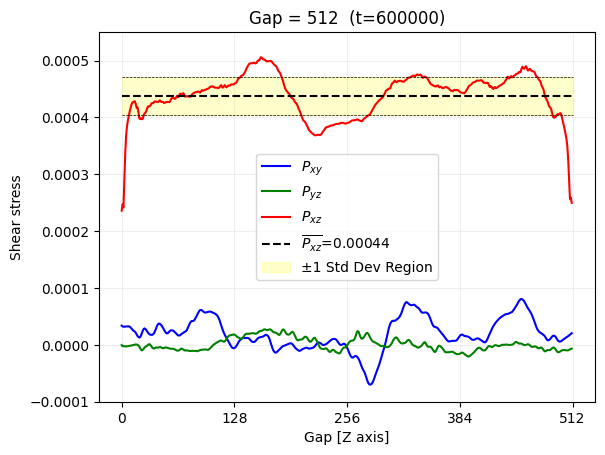

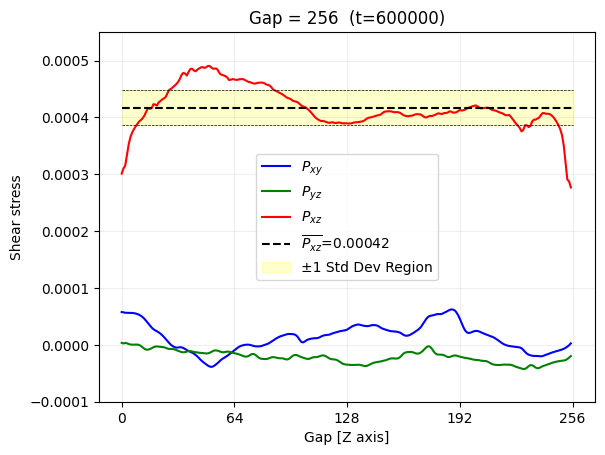

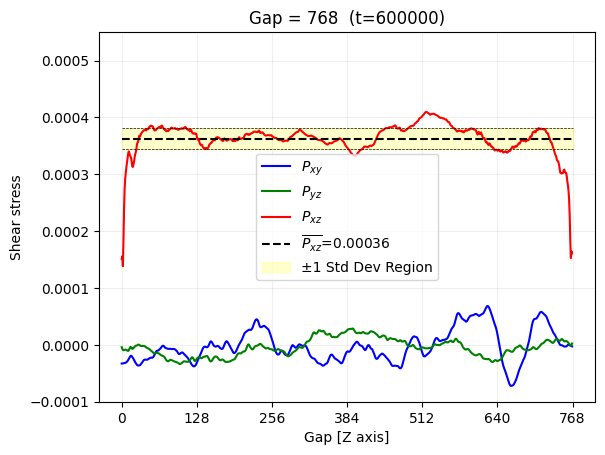

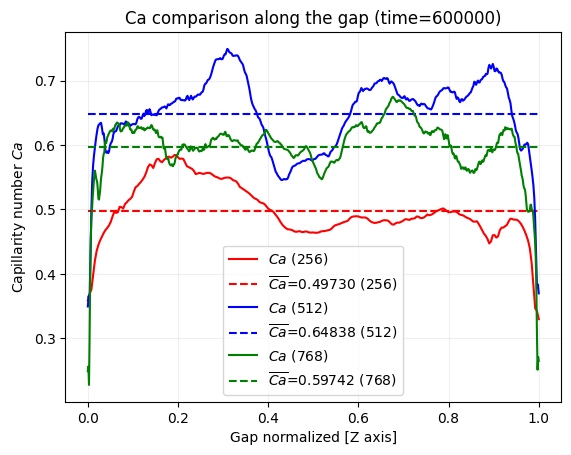

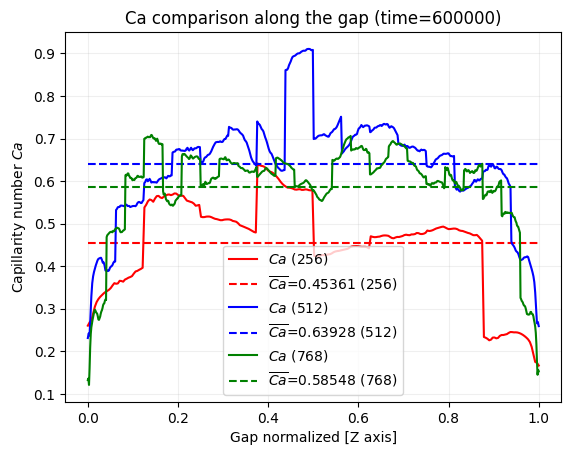

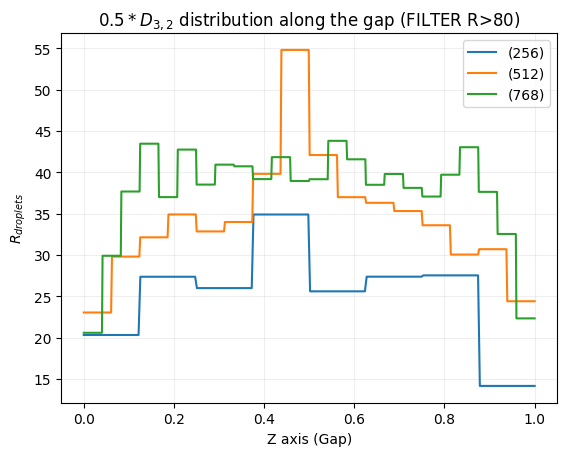

In [12]:
sigma = 0.0235
D32_256_ave = 28.0
D32_512_ave = 34.8
D32_768_ave = 38.7
SAVE = 1
save_dir = '/home/matti/Pictures/images_sst/'

def SST_p(i,f,name,sname,t):
    N = len(f[0,:])
    XT = np.linspace(0,N,t)
    _ = plt.figure(i)
    _ = plt.plot(f[0,:], color='blue' , label=r"$P_{xy}$")
    _ = plt.plot(f[2,:], color='green', label=r"$P_{yz}$")
    _ = plt.plot(f[1,:], color='red'  , label=r"$P_{xz}$")
    aveP = np.average(f[1,:])
    stdP = np.sqrt(np.var(f[1,10:-10]))
    _ = plt.hlines(aveP, 0, N, color='black', linestyle = '--', label=r"$\overline{P_{xz}}$=%1.5f"%aveP)
    _ = plt.hlines([aveP+stdP,aveP-stdP], 0, N, color='black', linewidth=0.5, linestyle = '--')
    _ = plt.fill_between(XT, aveP-stdP, aveP+stdP, color='yellow', alpha=0.2, label='±1 Std Dev Region')
    _ = plt.title(name)
    _ = plt.ylim([-0.0001,0.00055])
    _ = plt.ylabel('Shear stress')
    _ = plt.xlabel('Gap [Z axis]')
    _ = plt.xticks(XT)
    _ = plt.grid(alpha=0.2)
    _ = plt.legend()
    if SAVE:
        _ = plt.savefig(save_dir+sname+'.png', bbox_inches='tight', dpi=300, format='png')
SST_p(0, SST512a_ave, 'Gap = 512  (t=600000)', 'SSTxz_512', 5)
SST_p(1, SST256a_ave, 'Gap = 256  (t=600000)', 'SSTxz_256', 5)
SST_p(2, SST768a_ave, 'Gap = 768  (t=600000)', 'SSTxz_768', 7)


_  = plt.figure(100)
XX = np.linspace(0,1,Nz256)
fp = SST256a_ave[1,:]*D32_256_ave/sigma
_  = plt.plot(XX,fp, color='red' , label=r"$Ca$ (256)")
aveP = np.average(fp)
_  = plt.hlines(aveP, 0, 1, color='red', linestyle = '--', label=r"$\overline{Ca}$=%1.5f (256)"%aveP)
XX = np.linspace(0,1,Nz512)
fp = SST512a_ave[1,:]*D32_512_ave/sigma
_  = plt.plot(XX, fp, color='blue' , label=r"$Ca$ (512)")
aveP = np.average(fp)
_  = plt.hlines(aveP, 0, 1, color='blue', linestyle = '--', label=r"$\overline{Ca}$=%1.5f (512)"%aveP)
XX = np.linspace(0,1,Nz768)
fp = SST768a_ave[1,:]*D32_768_ave/sigma
_  = plt.plot(XX, fp, color='green' , label=r"$Ca$ (768)")
aveP = np.average(fp)
_ = plt.hlines(aveP, 0, 1, color='green', linestyle = '--', label=r"$\overline{Ca}$=%1.5f (768)"%aveP)
_ = plt.title('Ca comparison along the gap (time=600000)')
_ = plt.ylabel(r'Capillarity number $Ca$')
_ = plt.xlabel('Gap normalized [Z axis]')
_ = plt.grid(alpha=0.2)
_ = plt.legend()
if SAVE:
    _ = plt.savefig(save_dir+'Ca_R_ave_whole.png', bbox_inches='tight', dpi=300, format='png')


_  = plt.figure(101)
XX = np.linspace(0,1,Nz256)
fp = SST256a_ave[1,:]*distr_RD32_256/sigma
_  = plt.plot(XX,fp, color='red' , label=r"$Ca$ (256)")
aveP = np.average(fp)
_  = plt.hlines(aveP, 0, 1, color='red', linestyle = '--', label=r"$\overline{Ca}$=%1.5f (256)"%aveP)
XX = np.linspace(0,1,Nz512)
fp = SST512a_ave[1,:]*distr_RD32_512/sigma
_  = plt.plot(XX, fp, color='blue' , label=r"$Ca$ (512)")
aveP = np.average(fp)
_  = plt.hlines(aveP, 0, 1, color='blue', linestyle = '--', label=r"$\overline{Ca}$=%1.5f (512)"%aveP)
XX = np.linspace(0,1,Nz768)
fp = SST768a_ave[1,:]*distr_RD32_768/sigma
_  = plt.plot(XX, fp, color='green' , label=r"$Ca$ (768)")
aveP = np.average(fp)
_ = plt.hlines(aveP, 0, 1, color='green', linestyle = '--', label=r"$\overline{Ca}$=%1.5f (768)"%aveP)
_ = plt.title('Ca comparison along the gap (time=600000)')
_ = plt.ylabel(r'Capillarity number $Ca$')
_ = plt.xlabel('Gap normalized [Z axis]')
_ = plt.grid(alpha=0.2)
_ = plt.legend()
if SAVE:
    _ = plt.savefig(save_dir+'Ca_R_ave_XYbin.png', bbox_inches='tight', dpi=300, format='png')


_ = plt.figure(200)
XX = np.linspace(0,1,Nz256)
_ = plt.plot(XX, distr_RD32_256, label=r"(256)")
XX = np.linspace(0,1,Nz512)
_ = plt.plot(XX, distr_RD32_512, label=r"(512)")
XX = np.linspace(0,1,Nz768)
_ = plt.plot(XX, distr_RD32_768, label=r"(768)")
_ = plt.ylabel('$R_{droplets}$')
_ = plt.xlabel('Z axis (Gap)')
_ = plt.legend()
_ = plt.grid(alpha=0.2)
name = r'$0.5*D_{3,2}$ distribution along the gap' 
savename = 'R_D32_gap_distrib'
if FILTER:
    _ = plt.title(name+' (FILTER R>%d)'%RF)
    savename += '_filter'
else:
    _ = plt.title(name)
if SAVE:
    _ = plt.savefig(save_dir+savename+".png", bbox_inches='tight', dpi=300, format='png')